# Automated Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 8, 2021

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
lkupclientid = 36 # Calgary Flames

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrFlames].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(38813, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38813 entries, 0 to 38812
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            38813 non-null  int64  
 1   dimCustomerMasterId     38813 non-null  int64  
 2   customerNumber          38813 non-null  object 
 3   year                    38813 non-null  object 
 4   productGrouping         38813 non-null  object 
 5   totalSpent              38813 non-null  float64
 6   recentDate              38813 non-null  object 
 7   attendancePercent       38813 non-null  float64
 8   renewedBeforeDays       38812 non-null  float64
 9   isBuyer                 38813 non-null  object 
 10  source_tenure           38813 non-null  int64  
 11  tenure                  38812 non-null  float64
 12  distToVenue             38813 non-null  float64
 13  totalGames              38813 non-null  int64  
 14  recency                 38813 non-null

### Let's drop the features that have lots of null values, and any ID columns, as these won't be useful to our model:

In [6]:
df.drop([
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity'],
    axis=1, 
    inplace=True
)

df.shape

(38813, 50)

### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [7]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(38813, 29)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [8]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38813 entries, 0 to 38812
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   totalSpent              38813 non-null  float64
 1   attendancePercent       38813 non-null  float64
 2   renewedBeforeDays       38812 non-null  float64
 3   source_tenure           38813 non-null  int64  
 4   tenure                  38812 non-null  float64
 5   totalGames              38813 non-null  int64  
 6   recency                 38813 non-null  int64  
 7   missed_games_1          38813 non-null  int64  
 8   missed_games_2          38813 non-null  int64  
 9   send_email              38813 non-null  int64  
 10  is_Lockdown             38813 non-null  int64  
 11  NumberofGamesPerSeason  38813 non-null  int64  
 12  isNextYear_Buyer        38813 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 3.8 MB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [9]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,totalSpent,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,recency,missed_games_1,missed_games_2,send_email,is_Lockdown,NumberofGamesPerSeason,isNextYear_Buyer
totalSpent,1.00,0.01,0.12,0.18,0.10,0.24,-0.02,0.18,0.16,-0.10,0.03,0.03,0.06
attendancePercent,0.01,1.00,0.02,0.05,-0.05,0.18,-0.37,-0.27,-0.35,0.02,-0.07,-0.05,0.08
renewedBeforeDays,0.12,0.02,1.00,0.29,-0.38,0.75,-0.10,0.39,0.15,-0.15,-0.50,-0.29,0.57
source_tenure,0.18,0.05,0.29,1.00,0.22,0.28,-0.03,0.12,0.03,-0.03,-0.04,-0.02,0.17
tenure,0.10,-0.05,-0.38,0.22,1.00,-0.19,0.11,-0.06,0.01,0.22,0.59,0.41,-0.46
totalGames,0.24,0.18,0.75,0.28,-0.19,1.00,-0.17,0.44,0.10,-0.07,-0.53,-0.42,0.59
recency,-0.02,-0.37,-0.10,-0.03,0.11,-0.17,1.00,0.03,0.13,0.00,0.18,0.12,-0.09
missed_games_1,0.18,-0.27,0.39,0.12,-0.06,0.44,0.03,1.00,0.29,-0.07,-0.30,-0.26,0.25
missed_games_2,0.16,-0.35,0.15,0.03,0.01,0.10,0.13,0.29,1.00,-0.05,-0.10,-0.08,0.07
send_email,-0.10,0.02,-0.15,-0.03,0.22,-0.07,0.00,-0.07,-0.05,1.00,0.07,-0.01,-0.11


### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [10]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (31050, 13)
Unseen Data For Predictions: (7763, 13)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [14]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    numeric_features=[
        "missed_games_1",
        "missed_games_2",
        "renewedBeforeDays",
        "send_email",
        "source_tenure",
        "tenure"    
    ]
);

In [15]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.9347,0.9606,0.9801,0.9178,0.9479,0.8608,0.8642,0.0670
2,Gradient Boosting Classifier,0.9343,0.9609,0.9793,0.9177,0.9475,0.8598,0.8631,0.3290
9,Extreme Gradient Boosting,0.9326,0.9589,0.9769,0.9172,0.9461,0.8563,0.8593,0.8530
7,Random Forest Classifier,0.9306,0.9547,0.9712,0.9189,0.9443,0.8523,0.8546,0.3120
0,Ada Boost Classifier,0.9298,0.9590,0.9767,0.9134,0.9440,0.8501,0.8536,0.2800
8,NGBClassifier,0.9281,0.9601,0.9754,0.9121,0.9427,0.8466,0.8501,4.9590
3,Extra Trees Classifier,0.9263,0.9492,0.9643,0.9182,0.9407,0.8435,0.8453,0.3290
4,K Neighbors Classifier,0.8928,0.9223,0.9495,0.8826,0.9148,0.7709,0.7747,0.0690
1,Decision Tree Classifier,0.8868,0.8868,0.8975,0.9142,0.9058,0.7642,0.7645,0.0340
6,Logistic Regression,0.8591,0.9079,0.9096,0.8654,0.8867,0.7005,0.7029,0.1330


### The top model is performing well, so let's compare it against our unseen eval dataset:

In [16]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9300,0.9522,0.9781,0.9126,0.9442,0.8504,0.8541
1,0.9328,0.9551,0.9807,0.9145,0.9465,0.8564,0.8602
2,0.9263,0.9583,0.9774,0.9080,0.9414,0.8425,0.8467
3,0.9368,0.9609,0.9834,0.9181,0.9496,0.8651,0.8688
4,0.9444,0.9676,0.9807,0.9312,0.9553,0.8820,0.8841
5,0.9267,0.9532,0.9767,0.9091,0.9417,0.8435,0.8474
6,0.9380,0.9641,0.9774,0.9246,0.9503,0.8682,0.8705
7,0.9336,0.9601,0.9801,0.9161,0.9470,0.8583,0.8618
8,0.9376,0.9693,0.9847,0.9182,0.9503,0.8668,0.8706
9,0.9412,0.9656,0.9814,0.9260,0.9529,0.8750,0.8776


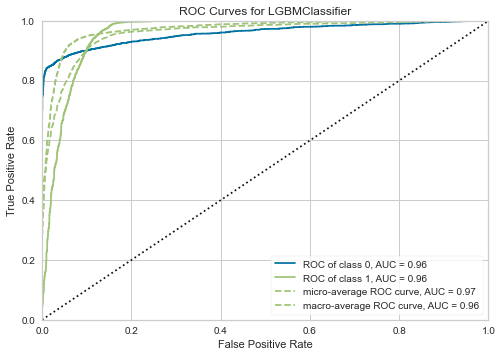

In [17]:
plot_model(best_model, plot='auc')

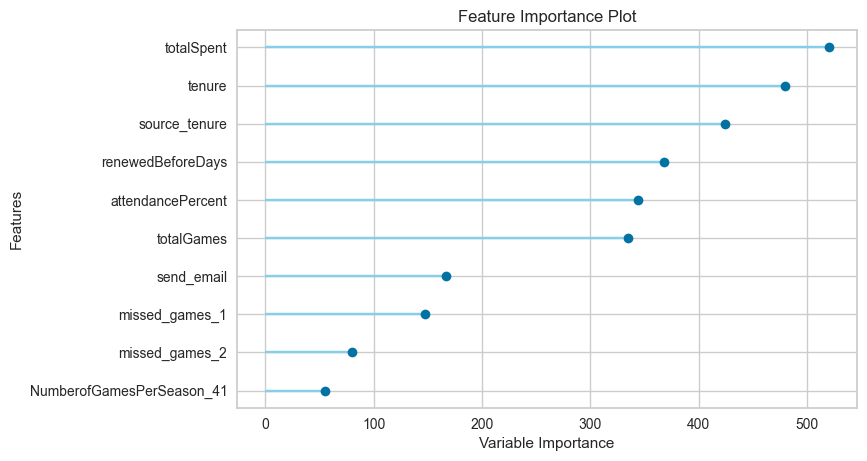

In [18]:
plot_model(best_model, plot='feature')

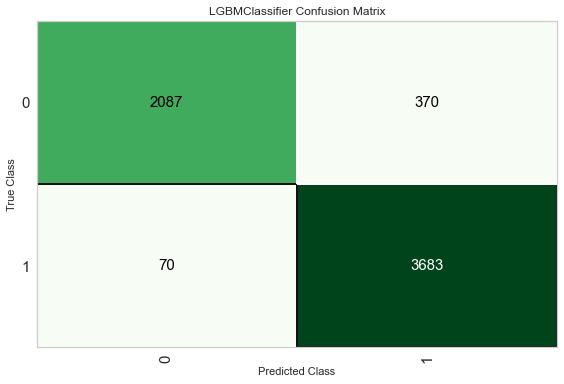

In [19]:
plot_model(best_model, plot='confusion_matrix')